# Using the Custom Hardware Image Generator

This notebook demonstrates hardware generation of an image stream and displaying it on the HDMI output. Before running it you will need to compile the example overlay with the frame generator in Verilog. Two files are generated:
- a `.bit` file, containing the FPGA configuration bitstream
- a `.hwh` (hardware handoff) file, containing information about the module heirarchy and memory map

Copy both files to the user home directory on the Pynq operating system. Then load them (loading the `.bit` also reads the `.hwh` of the same name):

In [12]:
from pynq import Overlay
from pynq.lib.video import *

overlay = Overlay("/home/xilinx/multi_engine_5_3.bit")

#pixgen.register_map.gp0 = 0x1234
#print(pixgen.register_map.gp0)

# Which registers holding which pixels // gpo: zoom, gp1: max_iter, gp2: x_offset, gp3: y_offset 






RuntimeError: no validator found for <class 'object'>, see `arbitrary_types_allowed` in Config

In [11]:
import nest_asyncio
nest_asyncio.apply()

In [10]:
!pip uninstall fastapi starlette uvicorn typing_extensions pydantic anyio exceptiongroup -y
!pip install --no-deps "fastapi==0.68.0" "starlette==0.14.2" "uvicorn==0.15.0" "pydantic==1.8.2" --force-reinstall
!pip install typing_extensions

Found existing installation: fastapi 0.68.0
Uninstalling fastapi-0.68.0:
  Successfully uninstalled fastapi-0.68.0
Found existing installation: starlette 0.14.2
Uninstalling starlette-0.14.2:
  Successfully uninstalled starlette-0.14.2
Found existing installation: uvicorn 0.15.0
Uninstalling uvicorn-0.15.0:
  Successfully uninstalled uvicorn-0.15.0
Found existing installation: typing_extensions 4.14.0
Uninstalling typing_extensions-4.14.0:
  Successfully uninstalled typing_extensions-4.14.0
  Using cached fastapi-0.68.0-py3-none-any.whl (52 kB)
  Using cached starlette-0.14.2-py3-none-any.whl (60 kB)
  Using cached uvicorn-0.15.0-py3-none-any.whl (54 kB)
  Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
  Using cached typing_extensions-4.14.0-py3-none-any.whl (43 kB)


In [8]:

import asyncio
import websockets
import json
import threading
from qformatpy import qformat
from pynq import Overlay
from pynq.lib.video import *
import PIL.Image
from io import BytesIO
import base64

# Install websockets if needed
try:
    import websockets
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "websockets"])
    import websockets

# PYNQ Setup
# overlay = Overlay("/home/xilinx/32_bit_zoom_2.bit")
imgen_vdma = overlay.video.axi_vdma_0.readchannel
pixgen = overlay.pixel_generator_0

videoMode = common.VideoMode(640, 480, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

def generate_frame_with_params(params):
    # Convert to Q4.28 format
    re_c_q = qformat(params.get('re_c', -0.5), 4, 28)
    im_c_q = qformat(params.get('im_c', 0.0), 4, 28)
    
    # Set FPGA registers
    pixgen.register_map.gp0 = params.get('max_iter', 200)       
    pixgen.register_map.gp1 = int(params.get('zoom', 1))            
    pixgen.register_map.gp2 = re_c_q   
    pixgen.register_map.gp3 = im_c_q

    # Generate frame
    frame = imgen_vdma.readframe()
    image = PIL.Image.fromarray(frame)
    im_file = BytesIO()
    image.save(im_file, format='PNG')

    # Return base64 data URI
    im_b64_string = base64.b64encode(im_file.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{im_b64_string}"

async def handle_websocket(websocket, path):
    print(f"Client connected from {websocket.remote_address}")
    try:
        async for message in websocket:
            try:
                params = json.loads(message)
                print(f"Received params: {params}")
                
                # Generate frame with FPGA
                base_rep = generate_frame_with_params(params)
                
                # Send back to client
                await websocket.send(base_rep)
                print("Sent fractal image to client")
                
            except json.JSONDecodeError as e:
                print(f"JSON decode error: {e}")
                await websocket.send(json.dumps({"error": "Invalid JSON"}))
            except Exception as e:
                print(f"Error processing message: {e}")
                await websocket.send(json.dumps({"error": str(e)}))
                
    except websockets.exceptions.ConnectionClosed:
        print("Client disconnected")
    except Exception as e:
        print(f"WebSocket error: {e}")

def start_websocket_server():
    # Create new event loop for this thread
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    
    # Start server on port 8000 (no routing needed)
    start_server = websockets.serve(handle_websocket, "0.0.0.0", 8000)
    loop.run_until_complete(start_server)
    print("WebSocket server running on ws://192.168.137.175:8000")
    loop.run_forever()

# Start server in background thread
server_thread = threading.Thread(target=start_websocket_server, daemon=True)
server_thread.start()

print("Starting WebSocket server...")
print("Server will be available at ws://192.168.137.175:8000")
print("No /websocket endpoint needed - connect directly to ws://192.168.137.175:8000")

# Keep the cell running
import time
time.sleep(2)
print("✅ WebSocket server is running!")

RuntimeError: no validator found for <class 'object'>, see `arbitrary_types_allowed` in Config

In [44]:
# Test cell - run this to check if server is working
import requests
import socket

# Test if port 8000 is open
def test_port(host, port):
    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(5)
        result = sock.connect_ex((host, port))
        sock.close()
        return result == 0
    except:
        return False

print(f"Port 8000 open on localhost: {test_port('localhost', 8000)}")
print(f"Port 8000 open on 192.168.137.175: {test_port('192.168.137.175', 8000)}")

# Test if any process is using port 8000
import subprocess
try:
    result = subprocess.run(['netstat', '-tulpn'], capture_output=True, text=True)
    lines = result.stdout.split('\n')
    port_8000_lines = [line for line in lines if ':8000' in line]
    if port_8000_lines:
        print("Processes using port 8000:")
        for line in port_8000_lines:
            print(line)
    else:
        print("❌ No process found using port 8000")
except:
    print("Could not check netstat")

Port 8000 open on localhost: True
Port 8000 open on 192.168.137.175: True
Processes using port 8000:
tcp        0      0 0.0.0.0:8000            0.0.0.0:*               LISTEN      1190/python3        
Client connected from ('192.168.137.1', 53361)
Received params: {'re_c': -0.5, 'im_c': 0, 'zoom': 1, 'max_iter': 200, 'colour_sch': 'classic'}
Sent fractal image to client


The overlay object is automatically configured with a Python attribute structure that allows you to access the hardware as Python objects. Appropriate driver classes are instantiated where a hardware block is recognised by the Pynq library. Here we get a convenient handle to the VDMA connected to the pixel generator:

In [23]:
imgen_vdma = overlay.video.axi_vdma_0.readchannel

Next, the image generator DMA is configured and started:

In [24]:
videoMode = common.VideoMode(640, 480, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

The VDMA continuously reads frames into a cycle of memory buffers. You can take software ownership of a frame and get a NumPy handle for it:

In [4]:
# Optional Debugging

print("Running:", imgen_vdma.running)
print("Started:", imgen_vdma.readchannel.running)
print("State:", imgen_vdma.readchannel.state)

Running: True


AttributeError: 'S2MMChannel' object has no attribute 'readchannel'

The frame can be displayed in the notebook using PiL:

In [23]:
# Ed Stott test code

from pynq import Overlay
from pynq.lib.video import *
import PIL.Image

overlay = Overlay("/home/xilinx/Kevin's_attempt.bit")
pg_vdma = overlay.video.axi_vdma_0
videoMode = common.VideoMode(640, 480, 24)
pg_vdma.readchannel.mode = videoMode
pg_vdma.readchannel.start()

frame = pg_vdma.readchannel.readframe()
image = PIL.Image.fromarray(frame)
image



KeyboardInterrupt



In [ ]:
import numpy as np
from PIL import Image

# Fixed-point constants (using 16-bit fractional part for precision)
FIXED_SCALE = 65536  # 2^16
FIXED_HALF = 32768   # 0.5 in fixed-point

def rgb_to_intensity(image_array):
    """Fixed-point RGB to intensity conversion"""
    if len(image_array.shape) == 3:
        # Use integer weights scaled by 65536 for fixed-point math
        # 0.299 * 65536 = 19595, 0.587 * 65536 = 38470, 0.114 * 65536 = 7471
        weights = np.array([19595, 38470, 7471], dtype=np.int32)
        img_int32 = image_array[...,:3].astype(np.int32)
        # Compute weighted sum and shift back to 8-bit range
        return np.sum(img_int32 * weights, axis=-1) >> 16
    else:
        return image_array

def intensity_to_rainbow(intensity):
    """Fixed-point rainbow colormap"""
    intensity = np.asarray(intensity, dtype=np.int32)
    
    # Scale hue to fixed-point: 300/255 * 65536 = 77241
    hue_fp = intensity * 77241 >> 8  # Equivalent to * (300/255) in fixed-point
    
    # Convert to 60-degree sectors (divide by 60 * 65536 = 3932160)
    # Use bit shift approximation: 60 * 65536 ≈ 2^22 / 1.07 ≈ >> 22 * 1.07
    sector = hue_fp // (60 * FIXED_SCALE)
    frac_fp = hue_fp - sector * (60 * FIXED_SCALE)
    frac_normalized = (frac_fp << 16) // (60 * FIXED_SCALE)  # Normalize to 0-65536
    
    # Fixed-point HSV to RGB
    p = 0
    q_fp = FIXED_SCALE - frac_normalized  # 1.0 - frac
    t_fp = frac_normalized                # frac
    
    # Vectorized selection using integer operations
    r_fp = np.select(
        [sector == 0, sector == 1, sector == 2, sector == 3, sector == 4, sector >= 5],
        [FIXED_SCALE, q_fp, p, p, t_fp, FIXED_SCALE],
        default=0
    )
    g_fp = np.select(
        [sector == 0, sector == 1, sector == 2, sector == 3, sector == 4, sector >= 5],
        [t_fp, FIXED_SCALE, FIXED_SCALE, q_fp, p, p],
        default=0
    )
    b_fp = np.select(
        [sector == 0, sector == 1, sector == 2, sector == 3, sector == 4, sector >= 5],
        [p, p, t_fp, FIXED_SCALE, FIXED_SCALE, q_fp],
        default=0
    )
    
    # Convert back to 8-bit (shift right by 8 since we want 0-255 range)
    r = (r_fp * 255) >> 16
    g = (g_fp * 255) >> 16
    b = (b_fp * 255) >> 16
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def intensity_to_fire(intensity):
    """Fixed-point fire colormap"""
    intensity = np.asarray(intensity, dtype=np.int32)
    
    # Convert to fixed-point normalized (0-65536 range)
    normalized_fp = (intensity << 16) // 255
    
    # Thresholds in fixed-point
    thresh_25 = FIXED_SCALE // 4      # 0.25
    thresh_50 = FIXED_SCALE // 2      # 0.5
    thresh_75 = (FIXED_SCALE * 3) // 4  # 0.75
    
    # Phase calculations in fixed-point
    phase1_fp = normalized_fp << 2  # * 4.0
    phase2_fp = (normalized_fp - thresh_25) << 2
    phase3_fp = (normalized_fp - thresh_50) << 2
    phase4_fp = (normalized_fp - thresh_75) << 2
    
    # Vectorized conditional assignment
    r_fp = np.select(
        [normalized_fp <= thresh_25, normalized_fp <= thresh_50, normalized_fp <= thresh_75, normalized_fp > thresh_75],
        [phase1_fp, FIXED_SCALE, FIXED_SCALE, FIXED_SCALE],
        default=0
    )
    g_fp = np.select(
        [normalized_fp <= thresh_25, normalized_fp <= thresh_50, normalized_fp <= thresh_75, normalized_fp > thresh_75],
        [0, phase2_fp, FIXED_SCALE, FIXED_SCALE],
        default=0
    )
    b_fp = np.select(
        [normalized_fp <= thresh_25, normalized_fp <= thresh_50, normalized_fp <= thresh_75, normalized_fp > thresh_75],
        [0, 0, phase3_fp, FIXED_HALF + phase4_fp],
        default=0
    )
    
    # Convert to 8-bit
    r = (r_fp * 255) >> 16
    g = (g_fp * 255) >> 16
    b = (b_fp * 255) >> 16
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def intensity_to_ocean(intensity):
    """Fixed-point ocean colormap"""
    intensity = np.asarray(intensity, dtype=np.int32)
    normalized_fp = (intensity << 16) // 255
    
    # Thresholds in fixed-point
    thresh_33 = (FIXED_SCALE * 33) // 100    # 0.33
    thresh_66 = (FIXED_SCALE * 66) // 100    # 0.66
    
    # Phase calculations
    phase1_fp = (normalized_fp * 178956) >> 16  # * 2.727 in fixed-point
    phase2_g_fp = 6554 + (((normalized_fp - thresh_33) * 59024) // thresh_33)  # 0.1 + progress * 0.9
    phase3_fp = ((normalized_fp - thresh_66) << 16) // (FIXED_SCALE - thresh_66)
    
    # Vectorized assignment
    r_fp = np.where(normalized_fp > thresh_66, phase3_fp, 0)
    
    g_fp = np.select(
        [normalized_fp <= thresh_33, normalized_fp <= thresh_66, normalized_fp > thresh_66],
        [phase1_fp, phase2_g_fp, FIXED_SCALE],
        default=0
    )
    
    # For b channel, need to handle the clipping
    b_base = FIXED_HALF + (normalized_fp * 98304) >> 16  # 0.5 + norm * 1.5
    b_clipped = np.clip(b_base, 0, FIXED_SCALE)
    
    b_fp = np.select(
        [normalized_fp <= thresh_33, normalized_fp <= thresh_66, normalized_fp > thresh_66],
        [b_clipped, FIXED_SCALE, FIXED_SCALE],
        default=0
    )
    
    # Convert to 8-bit
    r = (r_fp * 255) >> 16
    g = (g_fp * 255) >> 16
    b = (b_fp * 255) >> 16
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def intensity_to_grayscale(intensity):
    """Fixed-point grayscale (trivial case)"""
    gray = np.asarray(intensity, dtype=np.uint8)
    return np.broadcast_to(gray[..., np.newaxis], gray.shape + (3,)).copy()

def intensity_to_classic_wolfram(intensity):
    """Fixed-point Wolfram colormap"""
    intensity = np.asarray(intensity, dtype=np.int32)
    normalized_fp = (intensity << 16) // 255
    
    # Thresholds in fixed-point (0.2 intervals)
    thresh_20 = FIXED_SCALE // 5      # 0.2
    thresh_40 = (FIXED_SCALE * 2) // 5  # 0.4
    thresh_60 = (FIXED_SCALE * 3) // 5  # 0.6
    thresh_80 = (FIXED_SCALE * 4) // 5  # 0.8
    
    # Progress calculations (divide by 0.2 = multiply by 5)
    prog1_fp = normalized_fp * 5
    prog2_fp = (normalized_fp - thresh_20) * 5
    prog3_fp = (normalized_fp - thresh_40) * 5
    prog4_fp = (normalized_fp - thresh_60) * 5
    prog5_fp = (normalized_fp - thresh_80) * 5
    
    # Vectorized conditional assignment
    r_fp = np.select(
        [normalized_fp <= thresh_20, normalized_fp <= thresh_40, normalized_fp <= thresh_60, 
         normalized_fp <= thresh_80, normalized_fp > thresh_80],
        [FIXED_HALF - (prog1_fp >> 1), 0, 0, prog4_fp, FIXED_SCALE],
        default=0
    )
    g_fp = np.select(
        [normalized_fp <= thresh_20, normalized_fp <= thresh_40, normalized_fp <= thresh_60, 
         normalized_fp <= thresh_80, normalized_fp > thresh_80],
        [0, prog2_fp, FIXED_SCALE, FIXED_SCALE, FIXED_SCALE - prog5_fp],
        default=0
    )
    b_fp = np.select(
        [normalized_fp <= thresh_20, normalized_fp <= thresh_40, normalized_fp <= thresh_60, 
         normalized_fp <= thresh_80, normalized_fp > thresh_80],
        [FIXED_HALF + (prog1_fp >> 1), FIXED_SCALE, FIXED_SCALE - prog3_fp, 0, 0],
        default=0
    )
    
    # Convert to 8-bit
    r = (r_fp * 255) >> 16
    g = (g_fp * 255) >> 16
    b = (b_fp * 255) >> 16
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def apply_colormap_to_pil(pil_image, colormap_function):
    """Optimized PIL image colormap application"""
    img_array = np.asarray(pil_image)
    
    if img_array.ndim == 3 and img_array.shape[2] >= 3:
        intensity = rgb_to_intensity(img_array)
    else:
        intensity = img_array
    
    colored_array = colormap_function(intensity)
    return Image.fromarray(colored_array, 'RGB')

# Convenience functions for direct PIL usage
def pil_to_rainbow(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_rainbow)

def pil_to_fire(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_fire)

def pil_to_ocean(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_ocean)

def pil_to_grayscale(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_grayscale)

def pil_to_wolfram(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_classic_wolfram)

In [ ]:
def intensity_to_psychedelic(intensity):
    """Fixed-point psychedelic colormap with vibrant, shifting colors"""
    intensity = np.asarray(intensity, dtype=np.int32)
    normalized_fp = (intensity << 16) // 255
    
    # Create multiple sine-like waves using lookup tables for psychedelic effect
    # Use fixed-point approximation of sine waves with different frequencies
    
    # High frequency components for rapid color shifts
    wave1_fp = (normalized_fp * 8) & (FIXED_SCALE - 1)  # 8x frequency, wrap around
    wave2_fp = (normalized_fp * 12) & (FIXED_SCALE - 1)  # 12x frequency
    wave3_fp = (normalized_fp * 6) & (FIXED_SCALE - 1)   # 6x frequency
    
    # Create triangle wave approximations (more efficient than sine)
    # Triangle wave: goes 0->1->0 in each period
    triangle1 = np.where(wave1_fp < FIXED_HALF, 
                        wave1_fp << 1,  # Rising edge: 2x
                        (FIXED_SCALE << 1) - (wave1_fp << 1))  # Falling edge
    
    triangle2 = np.where(wave2_fp < FIXED_HALF,
                        wave2_fp << 1,
                        (FIXED_SCALE << 1) - (wave2_fp << 1))
    
    triangle3 = np.where(wave3_fp < FIXED_HALF,
                        wave3_fp << 1,
                        (FIXED_SCALE << 1) - (wave3_fp << 1))
    
    # Phase shift the waves for RGB channels
    # Red: Use triangle1 with phase shift
    r_phase = (triangle1 + (FIXED_SCALE // 3)) & (FIXED_SCALE - 1)
    r_fp = FIXED_HALF + (r_phase >> 1)  # Offset + amplitude/2
    
    # Green: Use triangle2 with different phase
    g_phase = (triangle2 + (FIXED_SCALE * 2 // 3)) & (FIXED_SCALE - 1)
    g_fp = FIXED_HALF + (g_phase >> 1)
    
    # Blue: Use triangle3 with another phase
    b_phase = triangle3
    b_fp = FIXED_HALF + (b_phase >> 1)
    
    # Add base intensity modulation to prevent completely dark regions
    intensity_mod = normalized_fp >> 2  # 25% of original intensity
    
    r_fp = np.clip(r_fp + intensity_mod, 0, FIXED_SCALE)
    g_fp = np.clip(g_fp + intensity_mod, 0, FIXED_SCALE)
    b_fp = np.clip(b_fp + intensity_mod, 0, FIXED_SCALE)
    
    # Convert to 8-bit
    r = (r_fp * 255) >> 16
    g = (g_fp * 255) >> 16
    b = (b_fp * 255) >> 16
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def pil_to_psychedelic(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_psychedelic)

In [ ]:
def intensity_to_psychedelic(intensity):
    """Fixed-point psychedelic colormap with vibrant, shifting colors"""
    intensity = np.asarray(intensity, dtype=np.int32)
    normalized_fp = (intensity << 16) // 255
    
    # Create multiple sine-like waves using lookup tables for psychedelic effect
    # Use fixed-point approximation of sine waves with different frequencies
    
    # High frequency components for rapid color shifts
    wave1_fp = (normalized_fp * 8) & (FIXED_SCALE - 1)  # 8x frequency, wrap around
    wave2_fp = (normalized_fp * 12) & (FIXED_SCALE - 1)  # 12x frequency
    wave3_fp = (normalized_fp * 6) & (FIXED_SCALE - 1)   # 6x frequency
    
    # Create triangle wave approximations (more efficient than sine)
    # Triangle wave: goes 0->1->0 in each period
    triangle1 = np.where(wave1_fp < FIXED_HALF, 
                        wave1_fp << 1,  # Rising edge: 2x
                        (FIXED_SCALE << 1) - (wave1_fp << 1))  # Falling edge
    
    triangle2 = np.where(wave2_fp < FIXED_HALF,
                        wave2_fp << 1,
                        (FIXED_SCALE << 1) - (wave2_fp << 1))
    
    triangle3 = np.where(wave3_fp < FIXED_HALF,
                        wave3_fp << 1,
                        (FIXED_SCALE << 1) - (wave3_fp << 1))
    
    # Phase shift the waves for RGB channels
    # Red: Use triangle1 with phase shift
    r_phase = (triangle1 + (FIXED_SCALE // 3)) & (FIXED_SCALE - 1)
    r_fp = FIXED_HALF + (r_phase >> 1)  # Offset + amplitude/2
    
    # Green: Use triangle2 with different phase
    g_phase = (triangle2 + (FIXED_SCALE * 2 // 3)) & (FIXED_SCALE - 1)
    g_fp = FIXED_HALF + (g_phase >> 1)
    
    # Blue: Use triangle3 with another phase
    b_phase = triangle3
    b_fp = FIXED_HALF + (b_phase >> 1)
    
    # Add base intensity modulation to prevent completely dark regions
    intensity_mod = normalized_fp >> 2  # 25% of original intensity
    
    r_fp = np.clip(r_fp + intensity_mod, 0, FIXED_SCALE)
    g_fp = np.clip(g_fp + intensity_mod, 0, FIXED_SCALE)
    b_fp = np.clip(b_fp + intensity_mod, 0, FIXED_SCALE)
    
    # Convert to 8-bit
    r = (r_fp * 255) >> 16
    g = (g_fp * 255) >> 16
    b = (b_fp * 255) >> 16
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def pil_to_psychedelic(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_psychedelic)

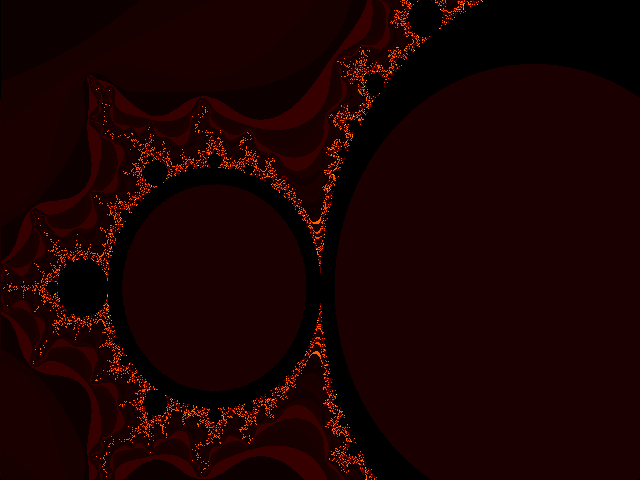

In [38]:
import PIL.Image

frame = imgen_vdma.readframe()
image = PIL.Image.fromarray(frame)
#print(frame)
image = pil_to_fire(image)
image



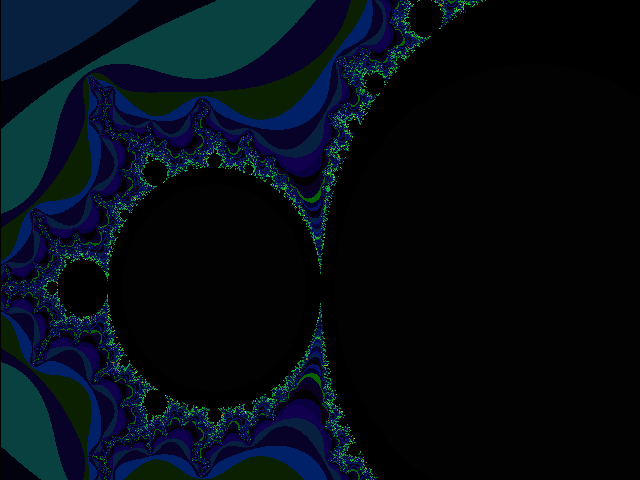

In [11]:
from io import BytesIO
import base64

def conv_to_b64(image):
    im_file = BytesIO()
    image.save(im_file, format='PNG')


    im_b64_string = base64.b64encode(im_file.getvalue()).decode('utf-8')
    data_url = f"data:image/jpeg;base64,{im_b64_string}"
    print(data_url)
    
conv_to_b64(image)

Matplotlib is building the font cache; this may take a moment.


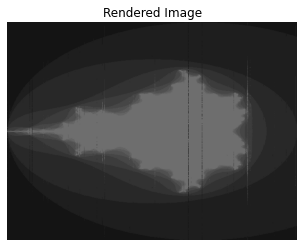

Saved to image_pixels.csv


/home/xilinx/jupyter_notebooks/image_pixels.csv

In [19]:
import PIL.Image
import numpy as np
import csv
import os

# Optional: Display inline image
from IPython.display import display, FileLink
import matplotlib.pyplot as plt

# --- Load or define the frame ---
# Assuming `frame` is already a NumPy array
image = PIL.Image.fromarray(frame)
pixels = np.array(image)

# Optional display
plt.imshow(image)
plt.title("Rendered Image")
plt.axis('off')
plt.show()

# --- Save as CSV ---
output_csv = "image_pixels.csv"

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    if pixels.ndim == 2:  # Grayscale
        for row in pixels:
            writer.writerow(row.tolist())

    elif pixels.ndim == 3 and pixels.shape[2] == 3:  # RGB
        for row in pixels:
            writer.writerow([f"{r},{g},{b}" for r, g, b in row])

    else:
        raise ValueError("Unsupported image shape")

print(f"Saved to {output_csv}")

# --- Show download link in Jupyter ---
display(FileLink(output_csv))




### HDMI Output
The HDMI output is handled with a wrapper object that configures both the VDMA and the HDMI output generator.

A bit of hacking is needed here: the image generator and its VDMA are in the same part of the design hierarchy (`video`) as the HDMI interface. The HDMI output wrapper `overlay.video.hdmi_out` picks up the image generator VDMA, not the one connected to HDMI, so that attribute needs to be changed to point to the correct VDMA.

After that, the HDMI output is configured and started:

In [27]:
hdmi_out = overlay.video.hdmi_out
hdmi_out._vdma = overlay.video.axi_vdma #Use the correct VDMA!
hdmi_out.configure(videoMode)
hdmi_out.start()

Now our frame can be sent to the HDMI output. At this stage ownership of the frame is transferred to the hardware, so it's no longer accessible to Python code. Connect a display to the HDMI port and you should see it.

In [28]:
# while True:
#     frame = imgen_vdma.readframe()
hdmi_out.writeframe(frame)

### MMIO Interface with Pixel Generator
You'll need to pass parameters to your image generator to change the visualisation at runtime. This is done with memory-mapped input/output, which allows software to modify registers in the logic. First get a handle to the Pixel Generator block and print its dictionary of registers:

In [ ]:
pixgen = overlay.pixel_generator_0
pixgen.register_map

In [41]:
frame

PynqBuffer([[[ 0,  0,  0],
             [ 8, 32,  0],
             [ 8, 32,  0],
             ...,
             [ 0,  0,  0],
             [ 0,  0,  0],
             [ 0,  0,  0]],

            [[ 0,  0,  0],
             [ 8, 32,  0],
             [ 8, 32,  0],
             ...,
             [ 0,  0,  0],
             [ 0,  0,  0],
             [ 0,  0,  0]],

            [[ 0,  0,  0],
             [ 8, 32,  0],
             [ 8, 32,  0],
             ...,
             [ 0,  0,  0],
             [ 0,  0,  0],
             [ 0,  0,  0]],

            ...,

            [[ 8,  2,  8],
             [ 8,  2,  8],
             [ 8,  2,  8],
             ...,
             [ 8,  2,  8],
             [ 8,  2,  8],
             [ 8,  2,  8]],

            [[ 0,  0,  0],
             [ 8,  2,  8],
             [ 8,  2,  8],
             ...,
             [ 8,  2,  8],
             [ 8,  2,  8],
             [ 0,  0,  0]],

            [[ 0,  0,  0],
             [ 8,  2,  8],
             [ 8, 

The registers can be modified directly as Python objects

In [ ]:
import PIL.Image
import time

# pixgen.register_map.gp0 = 0x10
# print(pixgen.register_map.gp0)

# Which registers holding which pixels // gpo: zoom, gp1: max_iter, gp2: x_offset, gp3: y_offset 

pixgen = overlay.pixel_generator_0
# pixgen.register_map

max_iter = 0x00C8
zoom = 0x0002
real_center = 0xF4000000
imag_center = 0x0199999A
zoom_reciprocal = 134217728 / 256
max_iter_reciprocal = 65536 // max_iter

pixgen.register_map.gp0 = max_iter
pixgen.register_map.gp1 = zoom
pixgen.register_map.gp2 = real_center
pixgen.register_map.gp3 = imag_center
pixgen.register_map.gp4 = zoom_reciprocal
pixgen.register_map.gp5 = max_iter_reciprocal

num_steps = 1000

for i in range (1,num_steps):
    frame = imgen_vdma.readframe()
    image = PIL.Image.fromarray(frame)
    hdmi_out.writeframe(frame)
    #zoom_rec = i
#     conv_to_b64(filtered_image)
    
#     frame = imgen_vdma.readframe()
#     image = PIL.Image.fromarray(frame)
#     filtered_image = pil_to_rainbow(image)
#     filtered_array = np.array(filtered_image)

#     # Copy the filtered data back into the original frame buffer
#     frame[:] = filtered_array  # This modifies the original frame object in-place

#     hdmi_out.writeframe(frame)  # Now writes the filtered frame
#     conv_to_b64(filtered_image)
    
   # pixgen.register_map.gp1 = i

In [ ]:
# SERVER CODE - Continuous streaming
import socket
import json
import numpy as np
import time

server_port = 12000
welcome_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
welcome_socket.bind(('0.0.0.0', server_port))
welcome_socket.listen(1)

print('Streaming server running on port', server_port)

while True:
    connection_socket, caddr = welcome_socket.accept()
    print(f"Streaming to {caddr}")
    
    try:
        # Send arrays continuously
        for i in range(100):  # Send 100 arrays
            # Generate changing data (simulate FPGA readings)
            numpy_array = np.random.rand(2, 3) * (i + 1)
            
            array_data = {
                'array': numpy_array.tolist(),
                'shape': numpy_array.shape,
                'dtype': str(numpy_array.dtype),
                'sequence': i
            }
            
            json_data = json.dumps(array_data) + '\n'  # Add newline delimiter
            connection_socket.send(json_data.encode())
            
            print(f"Sent array {i+1}/100")
           # time.sleep(0.5)  # Send every 0.5 seconds
            
    except Exception as e:
        print(f"Client disconnected: {e}")
    finally:
        connection_socket.close()

# CLIENT CODE - Receive streaming data
import socket
import json
import numpy as np

client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
client_socket.connect(('192.168.1.100', 12000))

print("Receiving streaming data...")

buffer = ""
try:
    while True:
        data = client_socket.recv(1024).decode()
        if not data:
            break
            
        buffer += data
        
        # Process complete JSON messages (delimited by newlines)
        while '\n' in buffer:
            line, buffer = buffer.split('\n', 1)
            
            try:
                array_data = json.loads(line)
                numpy_array = np.array(array_data['array'])
                seq = array_data['sequence']
                
                print(f"Array {seq+1}: shape={numpy_array.shape}, mean={numpy_array.mean():.2f}")
                
            except json.JSONDecodeError:
                continue
                
except KeyboardInterrupt:
    print("\nStopping...")
finally:
    client_socket.close()

Streaming server running on port 12000


Data that you write to register `n` is is available in `regfile[n]` in your logic

### Cleanup
Finally, stop the VDMAs so that the system is in a stable state at the end of the notebook

In [3]:
imgen_vdma.stop()
hdmi_out.close()

NameError: name 'imgen_vdma' is not defined

Todo:
- [ ] Copy multiple frames and find frame rate
- [ ] Link input and output for continuous video output without software control